# FIVES binary classification - fundus photography

Data: FIVES, original more clasees (eg more diseases)

For now, focus will be on binary classification: diabetic retinopathy present or not. (omitting classes for amd and glaucoma)

So left over are classes N (neutral) and DR (diabetic retinopathy).

Folder: Fives binary:

Train = 300 samples
test = 100 samples


DenseNet architecture based on paper c2 (which was referenced in c1, 36)

In [117]:
import os
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torch import nn, optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time


# Generic functions all models

### prep data

In [118]:
# get data
class DRData(Dataset):
    def __init__(self, root_dir, subset='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        subdir = f'{subset}/subset_ND'
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                self.image_paths.append(os.path.join(dir_path, filename))
                label = 1 if filename.split('_')[1].startswith('D') else 0 # so 1 for DR, 0 for NO DR
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
        
# transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # of naar 128 ?
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # also try when skipping normalize 
])

# Create dataset instances
full_train_dataset = DRData(root_dir='Data', subset='train', transform=data_transforms)
test_dataset = DRData(root_dir='Data', subset='test', transform=data_transforms)

# Split 
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


### Train + eval functions

In [119]:
""" 
Train
"""
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, saveName): # in the paper 75 epochs, but +- 5min per epoch
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Check time per epoch 

        model.train() # set model to train
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad() # zero grads

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward() #compute gradients
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) 

            predicted = torch.sigmoid(outputs).round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step() # update lr
        # for evaluation
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                predicted = torch.sigmoid(outputs).round()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        #for evaluation
        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time  # epoch time

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Time: {epoch_time:.2f} sec')

    # Plot train+val loss and acc
    epochs = range(num_epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # save weights
    torch.save(model.state_dict(), saveName)
    print("Model weights saved successfully.")

    return model 


""" 
Evaluation 

"""
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, cbar=False, square=True, linewidths=.5)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(ticks=[0.5, 1.5], labels=['No DR', 'DR'], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=['No DR', 'DR'], fontsize=12)
    plt.show()

    return accuracy, precision, recall, f1




""" 
for identifying wrongly classified samples 
"""
def wrong_images(model, test_loader):
    model.eval()
    wrongly_classified_images = []
    wrongly_classified_labels = []
    wrongly_classified_preds = []
    filenames = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                wrongly_classified_images.append(inputs[idx].cpu())
                wrongly_classified_labels.append(labels[idx].cpu().item())
                wrongly_classified_preds.append(preds[idx].cpu().item())
                filenames.append(test_loader.dataset.image_paths[idx])

    return wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames

def display_wrong_images(wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        if i < len(wrongly_classified_images):
            img = transforms.ToPILImage()(wrongly_classified_images[i])
            true_label = wrongly_classified_labels[i]
            pred_label = wrongly_classified_preds[i]
            filename = os.path.basename(filenames[i])
            axes[i].imshow(img)
            axes[i].set_title(f'{filename}\nTrue: {true_label}, Pred: {pred_label}')
            axes[i].axis('off')
        else:
            axes[i].axis('off')
    plt.show()


# 1+2 DenseNet-121 (not) Normalized > like paper c2

### DenseNet Specifics

Epoch 0/9, Train Loss: 0.0083, Train Accuracy: 96.08%, Val Loss: 0.0437, Val Accuracy: 80.00%, Time: 113.27 sec
Epoch 1/9, Train Loss: 0.0059, Train Accuracy: 97.25%, Val Loss: 0.0203, Val Accuracy: 91.11%, Time: 119.11 sec
Epoch 2/9, Train Loss: 0.0059, Train Accuracy: 97.65%, Val Loss: 0.0374, Val Accuracy: 84.44%, Time: 120.75 sec
Epoch 3/9, Train Loss: 0.0015, Train Accuracy: 99.61%, Val Loss: 0.0025, Val Accuracy: 100.00%, Time: 127.18 sec
Epoch 4/9, Train Loss: 0.0003, Train Accuracy: 100.00%, Val Loss: 0.0015, Val Accuracy: 100.00%, Time: 120.86 sec
Epoch 5/9, Train Loss: 0.0005, Train Accuracy: 100.00%, Val Loss: 0.0043, Val Accuracy: 97.78%, Time: 131.26 sec
Epoch 6/9, Train Loss: 0.0003, Train Accuracy: 100.00%, Val Loss: 0.0071, Val Accuracy: 97.78%, Time: 123.03 sec
Epoch 7/9, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0101, Val Accuracy: 97.78%, Time: 123.18 sec
Epoch 8/9, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0104, Val Accuracy: 97.78%, Ti

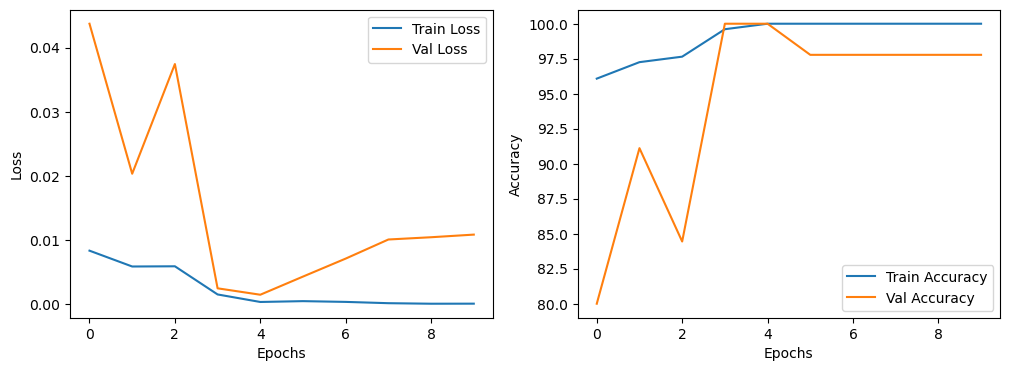

Model weights saved successfully.


In [66]:
# Define necessary params for model training 
#c2: " RETINA IMAGE AND DIABETIC RETINOPATHY: A DEEP LEARNING BASED APPROACH" 

# pre-trained DenseNet 121
model = models.densenet121(pretrained=True)

# binary classific
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1) # replace last layer witg new fully connected layer for binary 

# Switch to GPU (colab?)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function: binary cross entropy loss with logits: binary cross entropy between target & iput logit 
# focal loss emphasizes hard-to-classify samples (c2)
def focal_loss(inputs, targets, alpha=0.25, gamma=2): #alpha for class imbalance, however, not case here
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none') 
    pt = torch.exp(-BCE_loss) # prob per example: predicted prob of true class : pt is high = model is confident 
    F_loss = alpha * (1-pt)**gamma * BCE_loss # loss contribution lower for confident samples
    return F_loss.mean()

# adam optimizer & lr schedule: cosine annealing learning rate schedule 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# vars
num_epochs = 10
saveName = 'densenet121_NotNorm.pth' 

# Train the model
model = train_model(model, train_loader, val_loader, focal_loss, optimizer, scheduler, num_epochs, saveName)

/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[35 15]
 [ 0 50]]
Accuracy: 0.8500
Precision: 0.7692
Recall: 1.0000
F1 Score: 0.8696


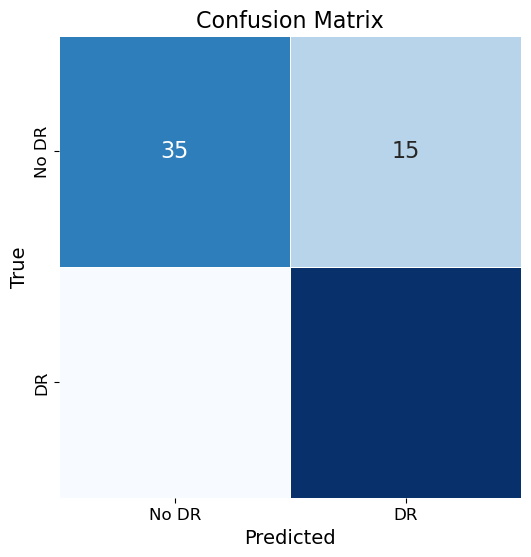

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model >> denseNet specific 
def load_model(saved_weights):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    return model


# Path to the saved model weights
saved_weights = 'densenet121_NotNorm.pth'

# Load the trained model
model = load_model(saved_weights)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

# 1 = DR
# 0 = No DR


# 3. Custom CNN

In [88]:
# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, saveName):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Check time per epoch 

        model.train() # set model to train
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad() # zero grads

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward() #compute gradients
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) 

            predicted = torch.sigmoid(outputs).round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step() # update lr
        # for evaluation
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                predicted = torch.sigmoid(outputs).round()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        #for evaluation
        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time  # epoch time

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Time: {epoch_time:.2f} sec')

    # Plot train+val loss and accuracy
    epochs = range(num_epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # save weights
    torch.save(model.state_dict(), saveName)
    print("Model weights saved successfully.")

    return model 

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, cbar=False, square=True, linewidths=.5)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(ticks=[0.5, 1.5], labels=['No DR', 'DR'], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=['No DR', 'DR'], fontsize=12)
    plt.show()

    return accuracy, precision, recall, f1

Epoch 0/24, Train Loss: 1.1989, Train Accuracy: 51.37%, Val Loss: 0.6899, Val Accuracy: 51.11%, Time: 35.54 sec
Epoch 1/24, Train Loss: 0.6843, Train Accuracy: 50.59%, Val Loss: 0.6832, Val Accuracy: 48.89%, Time: 36.82 sec
Epoch 2/24, Train Loss: 0.6595, Train Accuracy: 51.37%, Val Loss: 0.6526, Val Accuracy: 82.22%, Time: 37.62 sec
Epoch 3/24, Train Loss: 0.6512, Train Accuracy: 62.35%, Val Loss: 0.5877, Val Accuracy: 88.89%, Time: 37.86 sec
Epoch 4/24, Train Loss: 0.5266, Train Accuracy: 80.78%, Val Loss: 0.4271, Val Accuracy: 91.11%, Time: 38.44 sec
Epoch 5/24, Train Loss: 0.3474, Train Accuracy: 87.45%, Val Loss: 0.2724, Val Accuracy: 93.33%, Time: 38.19 sec
Epoch 6/24, Train Loss: 0.1958, Train Accuracy: 94.51%, Val Loss: 0.2225, Val Accuracy: 88.89%, Time: 39.55 sec
Epoch 7/24, Train Loss: 0.1390, Train Accuracy: 94.51%, Val Loss: 0.1715, Val Accuracy: 95.56%, Time: 38.60 sec
Epoch 8/24, Train Loss: 0.1264, Train Accuracy: 96.47%, Val Loss: 0.1659, Val Accuracy: 93.33%, Time: 39

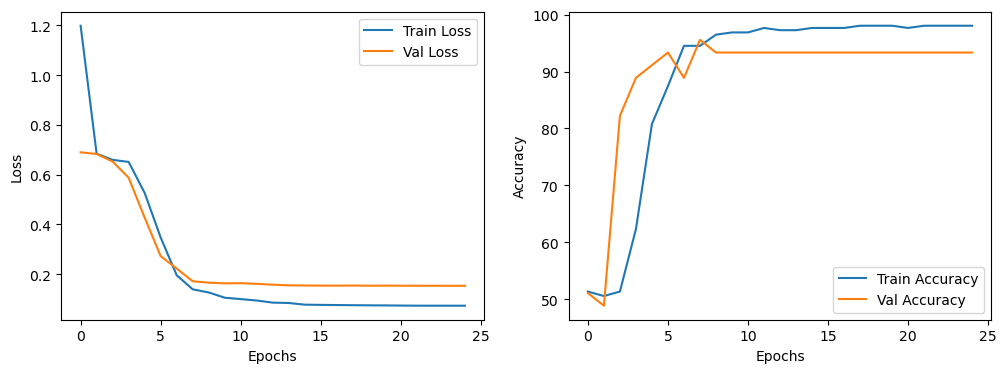

Model weights saved successfully.


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the custom CNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust based on the input size after conv and pool
        self.fc2 = nn.Linear(128, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Training and Evaluating the Custom CNN
model = CustomCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 25
saveName = 'custom_cnn.pth'

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, saveName)



[[22 28]
 [ 0 50]]
Accuracy: 0.7200
Precision: 0.6410
Recall: 1.0000
F1 Score: 0.7813


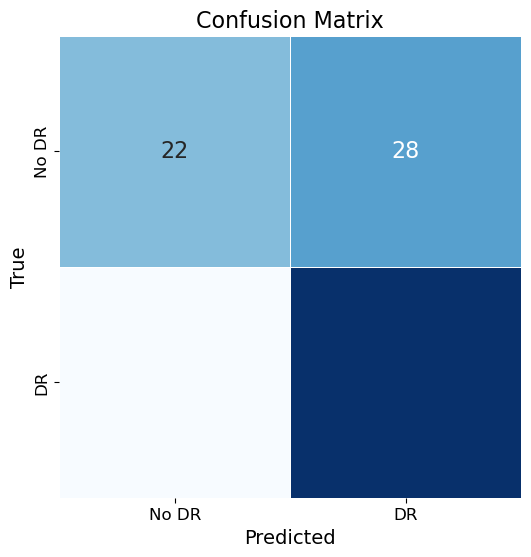

In [90]:
# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(trained_model, test_loader)

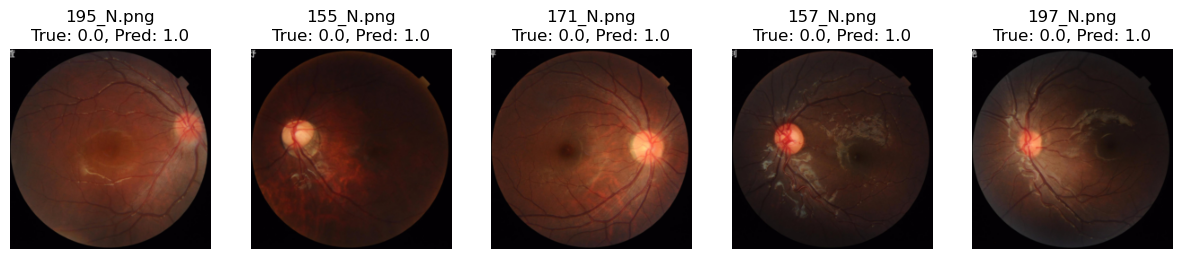

In [92]:

# Get wrongly classified images
wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames = wrong_images(trained_model, test_loader)

# Display tehm
display_wrong_images(wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames, num_images=5)


# 4. VGG11

/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/19, Train Loss: 0.1496, Train Accuracy: 46.67%, Val Loss: 0.0439, Val Accuracy: 40.00%, Time: 137.92 sec
Epoch 1/19, Train Loss: 0.0437, Train Accuracy: 48.24%, Val Loss: 0.1479, Val Accuracy: 40.00%, Time: 146.08 sec
Epoch 2/19, Train Loss: 0.0503, Train Accuracy: 55.29%, Val Loss: 0.0451, Val Accuracy: 40.00%, Time: 149.50 sec
Epoch 3/19, Train Loss: 0.0413, Train Accuracy: 59.22%, Val Loss: 0.0297, Val Accuracy: 73.33%, Time: 149.69 sec
Epoch 4/19, Train Loss: 0.0287, Train Accuracy: 84.31%, Val Loss: 0.0224, Val Accuracy: 91.11%, Time: 151.07 sec
Epoch 5/19, Train Loss: 0.0234, Train Accuracy: 86.27%, Val Loss: 0.0207, Val Accuracy: 93.33%, Time: 151.34 sec
Epoch 6/19, Train Loss: 0.0217, Train Accuracy: 89.02%, Val Loss: 0.0157, Val Accuracy: 93.33%, Time: 152.95 sec
Epoch 7/19, Train Loss: 0.0188, Train Accuracy: 90.59%, Val Loss: 0.0160, Val Accuracy: 93.33%, Time: 151.55 sec
Epoch 8/19, Train Loss: 0.0189, Train Accuracy: 90.98%, Val Loss: 0.0143, Val Accuracy: 91.11%, 

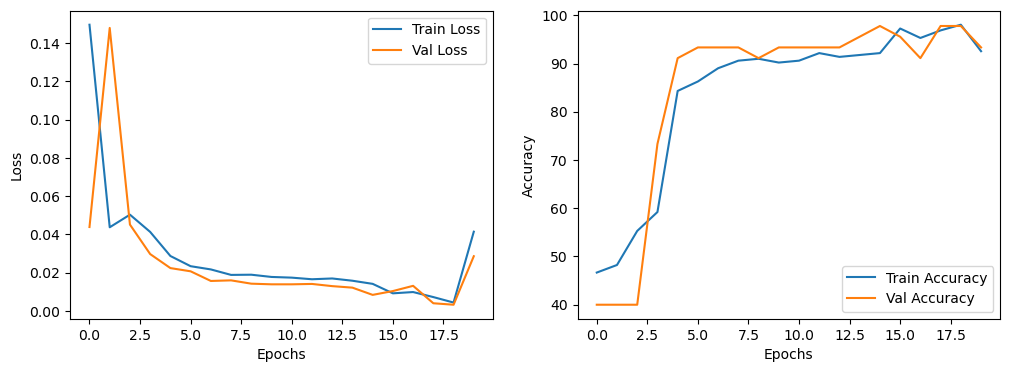

Model weights saved successfully.


In [122]:
# model specifics 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# pre-trained VGG 16
model = models.vgg16(pretrained=True)

# adjust for binary
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1) # replace last layer for binary 

model = model.to(device)

# Focal Loss function
def focal_loss(inputs, targets, alpha=0.25, gamma=2):
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = torch.exp(-BCE_loss)
    F_loss = alpha * (1-pt)**gamma * BCE_loss
    return F_loss.mean()

# optimizer en lr scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# vars
num_epochs = 20
saveName = 'VGG16_Weights.pth' 

# Train the model
model = train_model(model, train_loader, val_loader, focal_loss, optimizer, scheduler, num_epochs, saveName)

[[ 7 43]
 [ 7 43]]
Accuracy: 0.5000
Precision: 0.5000
Recall: 0.8600
F1 Score: 0.6324


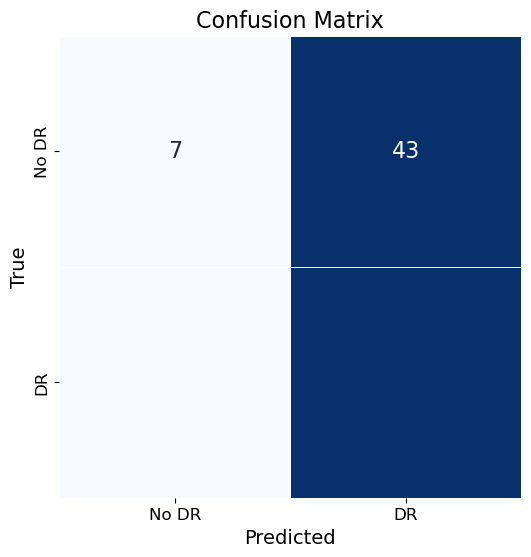

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model >> denseNet specific 
def load_model(saved_weights):
    model = models.vgg11(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    return model


# Path to the saved model weights
#saved_weights = 'VGG11_Weights.pth'

# Load the trained model
#model = load_model(saved_weights)

# Move model to GPU if available
model = model.to(device)

# Load the saved weights
model.load_state_dict(torch.load('VGG16_Weights.pth'))


# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

# 1 = DR
# 0 = No DR


# 5. Custom DenseNet

In [106]:
# manual denseNet implementation
from collections import OrderedDict

class CustomDenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, num_classes=1):
        super(CustomDenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # init from torch repo
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))



Epoch 0/9, Train Loss: 0.0430, Train Accuracy: 73.33%, Val Loss: 0.0557, Val Accuracy: 53.33%, Time: 112.92 sec
Epoch 1/9, Train Loss: 0.0205, Train Accuracy: 85.49%, Val Loss: 0.0708, Val Accuracy: 48.89%, Time: 114.15 sec
Epoch 2/9, Train Loss: 0.0130, Train Accuracy: 94.12%, Val Loss: 0.2259, Val Accuracy: 53.33%, Time: 117.03 sec
Epoch 3/9, Train Loss: 0.0077, Train Accuracy: 94.90%, Val Loss: 0.2393, Val Accuracy: 53.33%, Time: 119.69 sec
Epoch 4/9, Train Loss: 0.0065, Train Accuracy: 96.08%, Val Loss: 0.1187, Val Accuracy: 57.78%, Time: 121.60 sec
Epoch 5/9, Train Loss: 0.0044, Train Accuracy: 96.47%, Val Loss: 0.0294, Val Accuracy: 84.44%, Time: 127.94 sec
Epoch 6/9, Train Loss: 0.0035, Train Accuracy: 98.04%, Val Loss: 0.0260, Val Accuracy: 84.44%, Time: 122.64 sec
Epoch 7/9, Train Loss: 0.0020, Train Accuracy: 99.22%, Val Loss: 0.0112, Val Accuracy: 93.33%, Time: 128.24 sec
Epoch 8/9, Train Loss: 0.0011, Train Accuracy: 99.61%, Val Loss: 0.0099, Val Accuracy: 93.33%, Time: 123

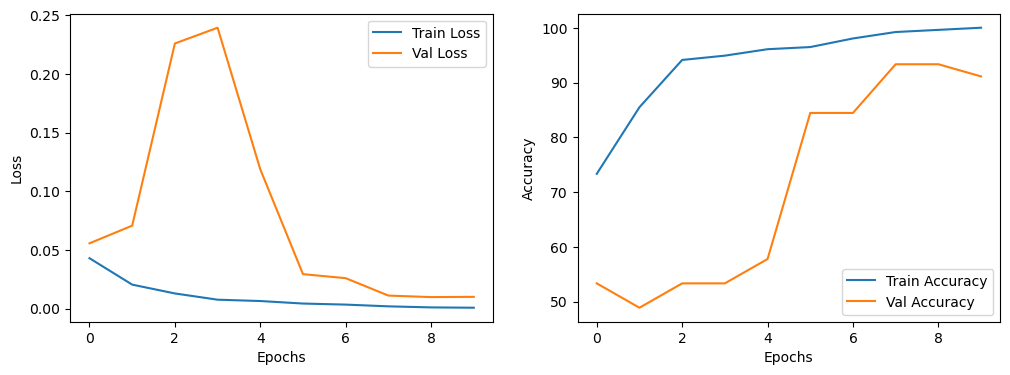

Model weights saved successfully.
[[16 34]
 [ 2 48]]
Accuracy: 0.6400
Precision: 0.5854
Recall: 0.9600
F1 Score: 0.7273


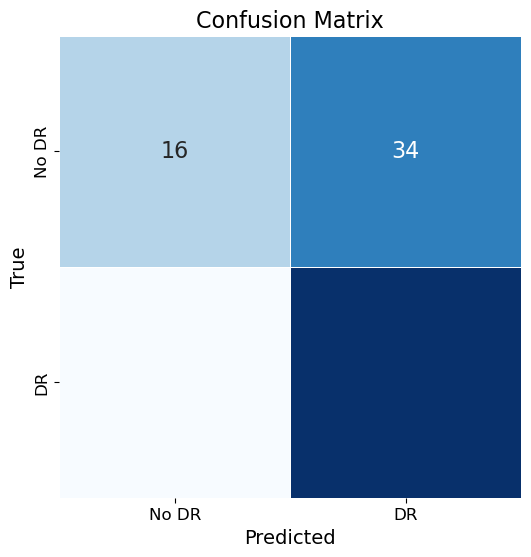

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# focal loss
def focal_loss(inputs, targets, alpha=0.25, gamma=2):
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = torch.exp(-BCE_loss)
    F_loss = alpha * (1-pt)**gamma * BCE_loss
    return F_loss.mean()

model = CustomDenseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train and evaluate the custom DenseNet model
num_epochs = 10
saveName = 'custom_densenet.pth'

# Train the model
trained_model = train_model(model, train_loader, val_loader, focal_loss, optimizer, scheduler, num_epochs, saveName)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(trained_model, test_loader)

# 6. Small Custom DenseNet

In [113]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F

class small_CustomDenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 16), num_init_features=64, bn_size=4, drop_rate=0, num_classes=1): # Skipped one block for th e block config (the 24)
        super(small_CustomDenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # init from torch repo
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


In [114]:
# Example of how to instantiate the modified DenseNet
model = small_CustomDenseNet()
print(model)

small_CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Epoch 0/9, Train Loss: 0.0353, Train Accuracy: 71.76%, Val Loss: 0.0638, Val Accuracy: 51.11%, Time: 95.98 sec
Epoch 1/9, Train Loss: 0.0224, Train Accuracy: 85.49%, Val Loss: 0.1036, Val Accuracy: 53.33%, Time: 98.65 sec
Epoch 2/9, Train Loss: 0.0159, Train Accuracy: 91.76%, Val Loss: 0.1267, Val Accuracy: 53.33%, Time: 102.81 sec
Epoch 3/9, Train Loss: 0.0145, Train Accuracy: 92.16%, Val Loss: 0.1744, Val Accuracy: 48.89%, Time: 104.50 sec
Epoch 4/9, Train Loss: 0.0116, Train Accuracy: 94.90%, Val Loss: 0.1063, Val Accuracy: 53.33%, Time: 111.28 sec
Epoch 5/9, Train Loss: 0.0064, Train Accuracy: 96.86%, Val Loss: 0.0727, Val Accuracy: 55.56%, Time: 108.92 sec
Epoch 6/9, Train Loss: 0.0054, Train Accuracy: 96.86%, Val Loss: 0.0205, Val Accuracy: 93.33%, Time: 110.91 sec
Epoch 7/9, Train Loss: 0.0048, Train Accuracy: 98.43%, Val Loss: 0.0357, Val Accuracy: 80.00%, Time: 110.67 sec
Epoch 8/9, Train Loss: 0.0049, Train Accuracy: 97.65%, Val Loss: 0.0075, Val Accuracy: 93.33%, Time: 111.2

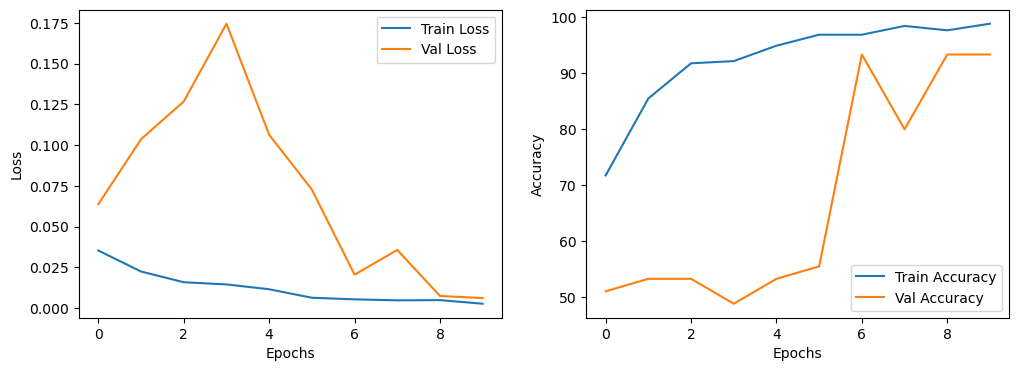

Model weights saved successfully.
[[12 38]
 [ 1 49]]
Accuracy: 0.6100
Precision: 0.5632
Recall: 0.9800
F1 Score: 0.7153


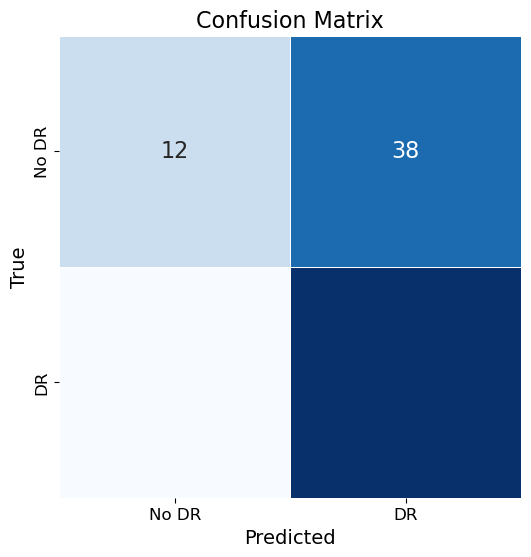

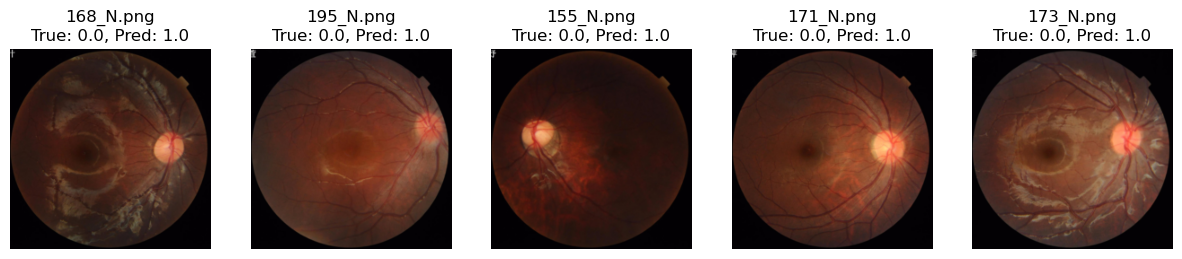

In [116]:

# Get wrongly classified images
wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames = wrong_images(trained_model, test_loader)
display_wrong_images(wrongly_classified_images, wrongly_classified_labels, wrongly_classified_preds, filenames, num_images=5)
